<a href="https://colab.research.google.com/github/lamtranBKHN/FaceDetector/blob/master/Face_Dectector12_4_128nodesHiddenSecondTry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from imutils import paths
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.applications import VGG16
from keras.layers import Input
from keras.models import Model
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Flatten
import numpy as np
import random
import os
from matplotlib import pyplot
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
import cv2
import pickle

In [0]:
IMG_SIZE = 224

file_list = []
class_list = []

DATADIR = "data"

# All the categories neural network will detect
CATEGORIES = ["Avicii", "Charlie_Puth","Den_Vau","Adam_Levine","Adele"]

# Checking or all images in the data folder
for category in CATEGORIES :
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)

training_data = []

def create_training_data():
    for category in CATEGORIES :
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try :
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

create_training_data()
random.shuffle(training_data)

X = [] #features
y = [] #labels

for features, label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)   
# Creating the files containing all the information about your model
pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

pickle_in = open("X.pickle", "rb")
X = pickle.load(pickle_in)

# Opening the files about data
X = pickle.load(open("X.pickle", "rb"))
y = pickle.load(open("y.pickle", "rb"))

# normalizing data (a pixel goes from 0 to 255)
X = X/255.0         

In [0]:
#from keras.utils import to_categorical
#y = to_categorical(y)
# Load model VGG 16 của ImageNet dataset, include_top=False để bỏ phần Fully connected lay
baseModel = VGG16(weights='imagenet', include_top=False, \
                  input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
# Buil layer
fcHead = baseModel.output
# Flatten 
fcHead = Flatten()(fcHead)
# Add FC
fcHead = Dense(1000, activation='relu')(fcHead)
fcHead = Dropout(0.5)(fcHead)
# Output layer with softmax activation
fcHead = Dense(5, activation='softmax')(fcHead)
# modle
model = model = Model(inputs=baseModel.input, outputs=fcHead)


58892288/58889256 [==============================] - 7s 0us/step


Train on 1636 samples, validate on 182 samples
Epoch 1/500
1636/1636 [==============================] - 40s 24ms/step - loss: 1.9002 - accuracy: 0.2066 - val_loss: 1.5525 - val_accuracy: 0.3242
Epoch 2/500
1636/1636 [==============================] - 23s 14ms/step - loss: 1.6305 - accuracy: 0.2616 - val_loss: 1.4322 - val_accuracy: 0.4780
Epoch 3/500
1636/1636 [==============================] - 24s 14ms/step - loss: 1.4584 - accuracy: 0.3802 - val_loss: 1.3434 - val_accuracy: 0.5604
Epoch 4/500
1636/1636 [==============================] - 24s 15ms/step - loss: 1.3604 - accuracy: 0.4480 - val_loss: 1.2539 - val_accuracy: 0.6703
Epoch 5/500
1636/1636 [==============================] - 24s 15ms/step - loss: 1.2760 - accuracy: 0.4982 - val_loss: 1.1623 - val_accuracy: 0.7033
Epoch 6/500
1636/1636 [==============================] - 24s 15ms/step - loss: 1.2042 - accuracy: 0.5446 - val_loss: 1.0775 - val_accuracy: 0.7143
Epoch 7/500
1636/1636 [==============================] - 24s 15ms/step 

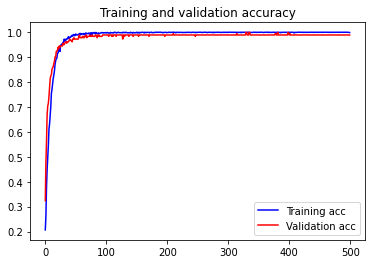

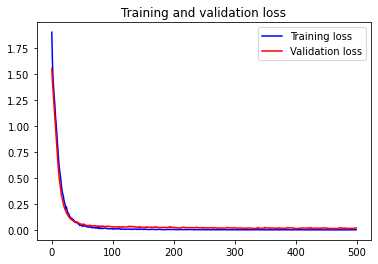

In [0]:
model.compile(loss = "sparse_categorical_crossentropy", 
                    optimizer = SGD(lr=1e-5, momentum=0.9), 
                    metrics=["accuracy"])
# Training the model.
X = np.array(X)
y = np.array(y)
history = model.fit(X, y, batch_size=32, epochs=500, validation_split=0.1)

# Saving the model
model_json = model.to_json()
with open("model.json", "w") as json_file :
    json_file.write(model_json)

model.save_weights("model2.h5")
print("Saved model to disk")

model.save('CNN2.model')

# Printing a graph showing the accuracy changes during the training phase
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
model = tf.keras.models.load_model("CNN2.model")

def test(filename, required_size=(IMG_SIZE, IMG_SIZE)):
    # load image from file
    pixels = pyplot.imread(filename)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width+ width//6, y1 + height + height//6

    if y1 > height//6:
      y1_new = y1 - height//6
    else:
      y1_new = y1
    if x1 > width//6:
      x1_new = x1 - width//6
    else:
      x1_new = x1
  
    # extract the face
    face = pixels[y1_new:y2, x1_new:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    # face_array = cv2.cvtColor(face_array, cv2.COLOR_BGR2GRAY)
    new_array = cv2.resize(face_array, (IMG_SIZE, IMG_SIZE)) 
    new_array = new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    prediction = model.predict([new_array])
    prediction = list(prediction[0])
    # get dimensions of image
    dimensions = pixels.shape
    height_IN = pixels.shape[0]
    width_IN = pixels.shape[1]

    cv2.putText(pixels,CATEGORIES[prediction.index(max(prediction))],
                (0,height_IN), 0, (width_IN)//200, 
                (255, 0, 255),height_IN//100, cv2.LINE_AA)
    
    pixels = cv2.rectangle(pixels,(x1_new,y1_new),
                           (x1 + width+ width//6,y1 + height + height//6),
                           (255,0,0),2)
    plt.imshow(pixels) 
    plt.show()
    print(prediction[prediction.index(max(prediction))]*100, '%')
    #return new_array



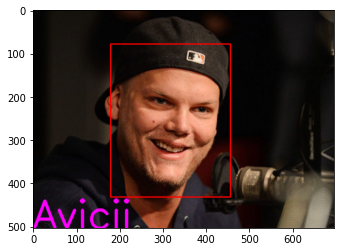

100.0 %


In [0]:
test("test_Avicii1.jpg")

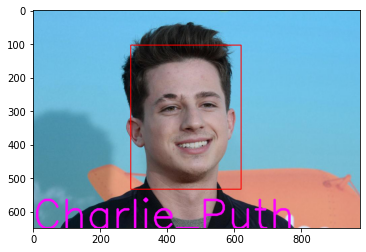

99.8364508152008 %


In [0]:
test("test_Charlie2.jpg")

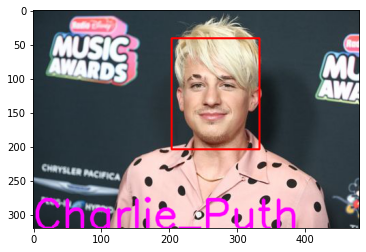

100.0 %


In [0]:
test('test_Charlie5.jpg')

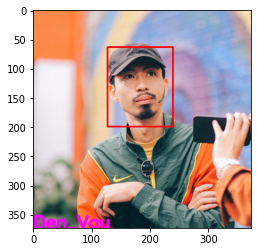

100.0 %


In [0]:
test('test_Den5.jpg')

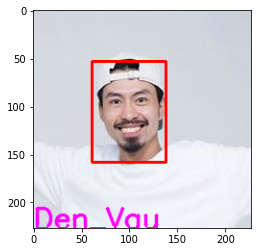

100.0 %


In [0]:
test('test_Den3.jpg')

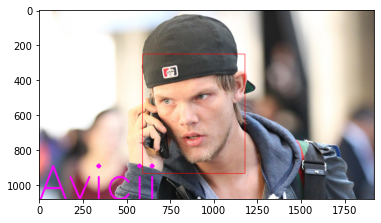

100.0 %


In [0]:
test('test_Avicii4.jpg')

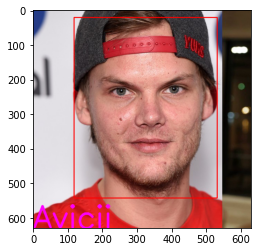

100.0 %


In [0]:
test('test_Avicii5.jpg')

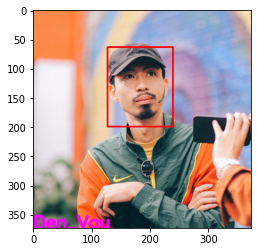

100.0 %


In [0]:
test('test_Den5.jpg')

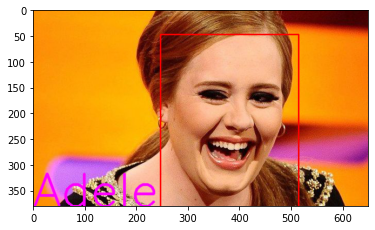

100.0 %


In [0]:
test('test_Adele1.jpg')

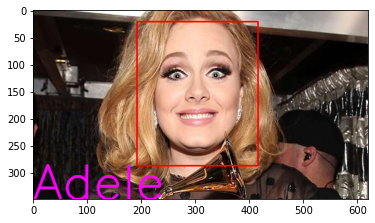

100.0 %


In [0]:
test('test_Adele2.jpg')

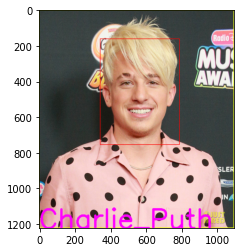

100.0 %


In [0]:
test("test_Charlie.jpg")

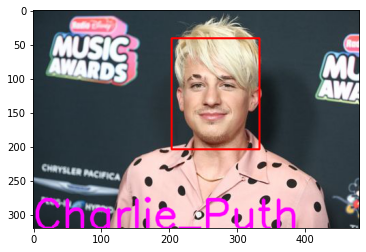

100.0 %


In [0]:
test("test_Charlie5.jpg")

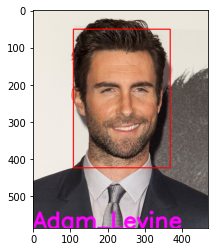

100.0 %


In [0]:
test("test_Adam1.jpg")

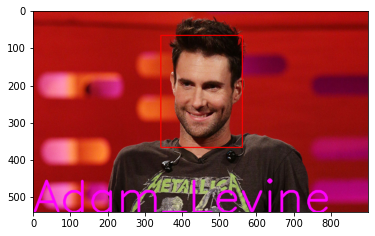

100.0 %


In [0]:
test("test_Adam3.jpg")

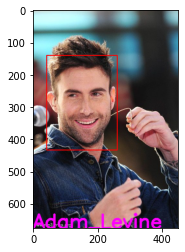

100.0 %


In [0]:
test("test_Adam4.jpg")

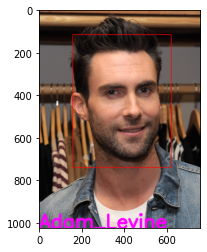

100.0 %


In [0]:
test("test_Adam5.jpg")

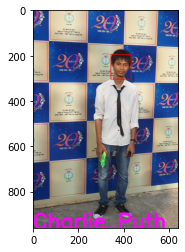

100.0 %


In [0]:
test('Lam.jpg')


In [0]:
#from google.colab import files
#files.download("model2.h5")

In [0]:
#from google.colab import files
#files.download("CNN2.model")